## タイタニックデータセットで予測値を出すまでの流れが中心

In [26]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
random_seed = 1234

## 前処理

In [27]:
def missing_value(df):
    # 欠損値フラグ
    df["Age_na"] = df["Age"].isnull().astype(np.int64)
    # 欠損値を中央値に
    df["Age"].fillna(df["Age"].median(), inplace=True)

missing_value(df_train)
missing_value(df_test)

In [28]:
df_train["Embarked"].fillna("S", inplace=True)
df_test["Fare"].fillna(df_test["Fare"].median(), inplace=True)

In [29]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Age_na           0
dtype: int64

In [30]:
def normalization(df, names):
    for name in names:
        df[name] = (df[name] - df[name].mean()) / df[name].std() # 不偏分散

names = ["Age", "Fare"]
normalization(df_train, names)
normalization(df_test, names)

In [31]:
def dummy(df):
    df = pd.get_dummies(df, 
                        columns=[
        "Pclass", "Sex", 
        #"SibSp", "Parch", 
        "Embarked"
                        ],
                        drop_first=True
                        
    )
    return df

df_train = dummy(df_train)
df_test = dummy(df_test)

In [32]:
select_columns = [
    'Age', 'SibSp', 'Parch', 'Fare', 
    'Age_na', 'Pclass_2', 'Pclass_3', 
    'Sex_male', 'Embarked_Q', 'Embarked_S'
]
target = "Survived"
print(select_columns)

['Age', 'SibSp', 'Parch', 'Fare', 'Age_na', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S']


In [33]:
from createModels import train

train_class = train()
train_class.fit(df_train, select_columns, target, random_seed)

正解率 0.798, 適合率 0.756, 再現率 0.699, F値 0.727 : AdaBoostClassifier
正解率 0.811, 適合率 0.785, 再現率 0.702, F値 0.741 : BaggingClassifier
正解率 0.813, 適合率 0.787, 再現率 0.702, F値 0.742 : ExtraTreesClassifier
正解率 0.835, 適合率 0.830, 再現率 0.716, F値 0.769 : GradientBoostingClassifier
正解率 0.827, 適合率 0.821, 再現率 0.705, F値 0.758 : RandomForestClassifier
正解率 0.814, 適合率 0.793, 再現率 0.696, F値 0.741 : GaussianProcessClassifier
正解率 0.806, 適合率 0.788, 再現率 0.678, F値 0.729 : LogisticRegressionCV
正解率 0.799, 適合率 0.767, 再現率 0.687, F値 0.724 : RidgeClassifierCV
正解率 0.749, 適合率 0.680, 再現率 0.652, F値 0.665 : BernoulliNB
正解率 0.779, 適合率 0.727, 再現率 0.678, F値 0.701 : GaussianNB
正解率 0.797, 適合率 0.762, 再現率 0.684, F値 0.721 : KNeighborsClassifier
正解率 0.781, 適合率 0.716, 再現率 0.714, F値 0.714 : DecisionTreeClassifier
正解率 0.773, 適合率 0.700, 再現率 0.716, F値 0.708 : ExtraTreeClassifier
正解率 0.799, 適合率 0.767, 再現率 0.687, F値 0.724 : LinearDiscriminantAnalysis
正解率 0.800, 適合率 0.763, 再現率 0.698, F値 0.728 : QuadraticDiscriminantAnalysis
正解率 0.819, 適合率 0.784, 再

In [34]:
# 提出
X = df_train[select_columns].to_numpy()
y = df_train[target].to_numpy()

X_test = df_test[select_columns].to_numpy()

model = sklearn.ensemble.RandomForestClassifier(random_state=random_seed)
model.fit(X, y)
pred_y = model.predict(X_test)

output = pd.DataFrame({"PassengerId": df_test["PassengerId"], "Survived": pred_y})
output.to_csv("result.csv", header=True, index=False)


## 説明変数の影響度

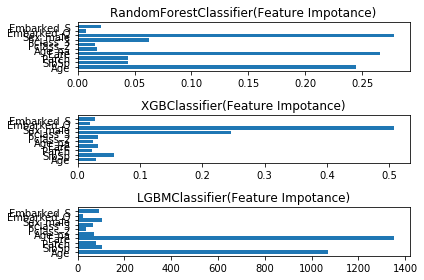

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def print_feature_importance(df, columns, target, random_seed):
    X = df[columns]
    y = df[target]
    
    model = sklearn.ensemble.RandomForestClassifier(random_state=random_seed)
    model.fit(X, y)
    fti1 = model.feature_importances_
    
    model = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False)
    model.fit(X, y)
    fti2 = model.feature_importances_
    
    model = lgb.LGBMClassifier(random_state=random_seed)
    model.fit(X, y)
    fti3 = model.feature_importances_
    
    fig = plt.figure()
    ax1 = fig.add_subplot(3,1,1,title="RandomForestClassifier(Feature Impotance)")
    ax2 = fig.add_subplot(3,1,2,title="XGBClassifier(Feature Impotance)")
    ax3 = fig.add_subplot(3,1,3,title="LGBMClassifier(Feature Impotance)")
    
    ax1.barh(columns, fti1)
    ax2.barh(columns, fti2)
    ax3.barh(columns, fti3)
    fig.tight_layout()
    plt.show()

print_feature_importance(df_train, select_columns, target, random_seed)

In [36]:
# 回帰分析

from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import statsmodels.api as sm

def print_statsmodels(df, columns, target):
    # 重回帰分析
    X = sm.add_constant(df[columns])
    y = df[target]
    model = sm.OLS(y, X)
    fitted = model.fit()
    
    print('summary = \n', fitted.summary())
    
    print('--- 重回帰分析の決定係数')
    for i, column in enumerate(columns):
        print('\t{:15s} : {:7.4f}(coef) {:5.1f}%(P>|t|)' .format(
            column, fitted.params[i+1], fitted.pvalues[i]*100
        ))
    print('')
    
    # クック距離
    print('--- 外れ値（cook_distance threshold:0.5）')
    for column in columns:
        # 単回帰
        x = sm.add_constant(df[column])
        model= sm.OLS(y, x)
        fitted = model.fit()
        
        cook_distance, p_value = OLSInfluence(fitted).cooks_distance
        kouho = np.where(cook_distance > 0.5)[0]
        if len(kouho) == 0:
            print("{:20s} cook_distance is 0(max: {:.4f})".format(column, np.max(cook_distance)))
        else:
            for index in kouho:
                print("{:20s} cook_distance: {}, index: {}".format(column, cook_distance[index], index))

    print("")

print_statsmodels(df_train, select_columns, target)

    

summary = 
                             OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     58.47
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.79e-90
Time:                        04:46:42   Log-Likelihood:                -394.97
No. Observations:                 891   AIC:                             811.9
Df Residuals:                     880   BIC:                             864.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0112      0.043     23.

## 説明変数同士の相関

--- 相関係数1:1 (threshold: 0.5)
Pclass_2 Pclass_3: -0.57



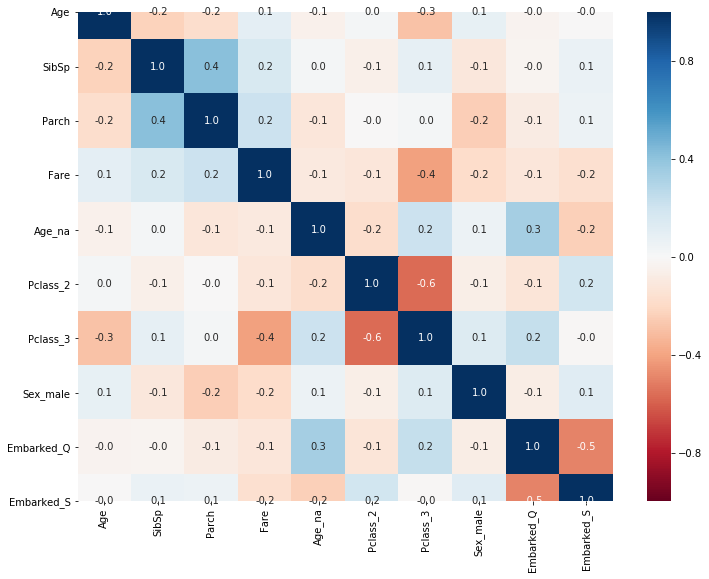

--- VIF(5以上だと怪しい)
   VIF Factor    features
0    1.186206         Age
1    1.583177       SibSp
2    1.628596       Parch
3    1.381285        Fare
4    1.450362      Age_na
5    2.026007    Pclass_2
6    4.517815    Pclass_3
7    2.771632    Sex_male
8    1.584157  Embarked_Q
9    4.120502  Embarked_S


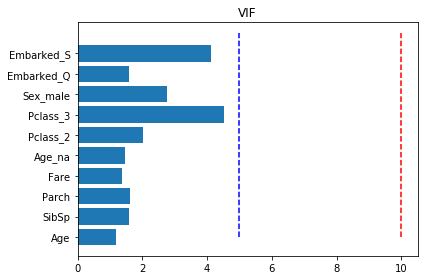

In [37]:
import seaborn as sns

def print_correlation(df, columns):
    #　相関係数1:1
    print("--- 相関係数1:1 (threshold: 0.5)")
    cor = df[columns].corr()
    count = 0
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            val = cor[columns[i]][j]
            if abs(val) > 0.5:
                print("{} {}: {:.2f}" .format(columns[i], columns[j], val))
                count += 1
    if count == 0:
        print('empty')
    print('')
    
    # heatmap
    plt.figure(figsize=(12,9))
    sns.heatmap(df[columns].corr(), annot=True, vmax=1, vmin=-1, fmt='.1f', cmap='RdBu')
    plt.show()

    
    # 相関係数1:多
    print('--- VIF(5以上だと怪しい)')
    vif = pd.DataFrame()
    X = df[columns]
    vif["VIF Factor"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    vif["features"] = columns
    print(vif)
    
    plt.barh(columns, vif["VIF Factor"])
    plt.vlines([5], 0, len(columns), "blue", linestyles="dashed")
    plt.vlines([10], 0, len(columns), "red", linestyles="dashed")
    plt.title('VIF')
    plt.tight_layout()
    plt.show()
    

print_correlation(df_train, select_columns)